In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn import metrics

df = pd.read_csv('/kaggle/input/smoking-driking-dataset-ver01/smoking_driking_dataset_Ver01.csv')
data = df.copy()
data.head()


In [ ]:
# Print summary statistics
print('The dataset has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
print(data.describe())

print(data.head())
data.dtypes.value_counts()
print(data.columns)
data.dtypes
numeric_attributes = data.columns[data.dtypes != "object"]
categorical_attributes = data.columns[data.dtypes == "object"]

print(numeric_attributes)
print(categorical_attributes)
# Print the total number of missing values
print("There are {} missing values in this dataset".format(data.isnull().sum().sum()))

print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

In [ ]:
from pandas.api.types import is_numeric_dtype

# For each column, if the column is categorical, print a count of each data category
for col in data.columns:
    if not is_numeric_dtype(data[col]):
        print(data[col].value_counts())

In [4]:
data = data.replace('N',0)
data = data.replace('Y',1)
data = data.replace('Male',0)
data = data.replace('Female',1)

freq_data = data[['sex', 'DRK_YN']]


freq_items = apriori(freq_data, min_support=0.1, use_colnames=True, verbose=1)
print(freq_items.head(7))

rules = association_rules(freq_items, metric="confidence", min_threshold=0.3)
print(rules.head())


Processing 2 combinations | Sampling itemset size 2
    support       itemsets
0  0.468990          (sex)
1  0.499813       (DRK_YN)
2  0.142403  (sex, DRK_YN)
  antecedents consequents  antecedent support  consequent support   support  \
0       (sex)    (DRK_YN)             0.46899            0.499813  0.142403   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.303639  0.607504 -0.092004    0.718286      -0.548879  


/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
x_cols = ['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN']
df1 = df[x_cols]

x_cats = ['sex', 'weight']
df2 = pd.get_dummies(df1, columns=x_cats)

# Sample data to reduce computational load
df2 = df2.sample(2000)

# Encode 'DRK_YN' column
df2['DRK_YN_encoded'] = df2['DRK_YN'].map({'N': 0, 'Y': 1})

# Drop the original 'DRK_YN' column
df2.drop(['DRK_YN'], axis=1, inplace=True)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(df2)

# Perform KMeans clustering with different numbers of clusters
numClusters = [1, 2, 3, 4, 5, 6, 7, 8, 9]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(X)
    SSE.append(k_means.inertia_)
    
# Plot SSE vs Number of Clusters
plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [ ]:
# Perform dimensionality reduction using t-SNE
pca = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
X2 = pca.fit_transform(X)

# Perform clustering with different numbers of clusters
range_n_clusters = [3, 4, 5]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Plot clusters in 2D
    colors = cm.nipy_spectral(df2['DRK_YN_encoded'].astype(float) / 2)
    ax2.scatter(
        X2[:, 0], X2[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Component 1")
    ax2.set_ylabel("Component 2")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
Y = data['DRK_YN']
X = data.drop(['sex','DRK_YN'],axis=1)
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
clf = clf.fit(X, Y)

In [ ]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left',
                                   'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
                                   'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST',
                                   'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd'], 
                                    class_names=['Male', 'Female'], 
                                    filled=True, rounded=True, fontsize=12)
plt.show()

In [ ]:
from sklearn.tree import export_text
tree_rules = export_text(clf, feature_names=['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left',
                                   'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
                                   'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST',
                                   'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd'])
print(tree_rules)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, test_x, y_train, test_lab = train_test_split(X,Y,test_size = 0.4,random_state = 42)
test_pred_decision_tree = clf.predict(test_x)
#import the relevant packages
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
#get the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_lab,test_pred_decision_tree)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(['Drink', 'Not-Drink'])
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(['Drink', 'not-Drink'], rotation = 0)
plt.show()

In [ ]:
print(metrics.classification_report(test_lab,test_pred_decision_tree))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random
%matplotlib inline
N = 1500
mean1 = [6, 14]
mean2 = [10, 6]
mean3 = [14, 14]
cov = [[3.5, 0], [0, 3.5]] # diagonal covariance
np.random.seed(50)
X = np.random.multivariate_normal(mean1, cov, int(N/6))
X = np.concatenate((X, np.random.multivariate_normal(mean2, cov, int(N/6))))
X = np.concatenate((X, np.random.multivariate_normal(mean3, cov, int(N/6))))
X = np.concatenate((X, 20*np.random.rand(int(N/2),2)))
Y = np.concatenate((np.ones(int(N/2)),np.zeros(int(N/2))))
plt.figure(figsize=(10,10))
plt.plot(X[:int(N/2),0],X[:int(N/2),1],'r+',X[int(N/2):,0],X[int(N/2):,1],'k.',ms=4)

In [ ]:
#########################################
# Training and Test set creation
#########################################
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=1)
from sklearn import tree
from sklearn.metrics import accuracy_score
#########################################
# Model fitting and evaluation
#########################################
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))
index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
#########################################
# Plot of training and test accuracies
#########################################
plt.plot(maxdepths,trainAcc,'ro-',maxdepths,testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

In [ ]:
#Import svm model
from sklearn import svm
#split the dataset
X_train, test_x, y_train, test_lab = train_test_split(X,Y,test_size = 0.3,random_state = 42)
#Create a svm Classifier
clf = svm.SVC(kernel='linear') 
# Linear Kernel
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(test_x)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_lab, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(test_lab, y_pred))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(test_lab, y_pred))

In [ ]:
data_sub = data[['sex', 'age', 'SMK_stat_type_cd', 'DRK_YN', 'weight']]

data_sub = pd.get_dummies(data_sub, columns=['sex'])
data_sub

In [ ]:
Y = data_sub['DRK_YN']  # We want to predict drinking status
X = data_sub.drop(['DRK_YN'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)


clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
# clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8)
clf = clf.fit(X, Y)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(x_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
      .format(clf.score(x_test, y_test)))

plt.figure(figsize=(25, 10))
tree.plot_tree(clf, feature_names=['age', 'sex', 'SMK_stat_type_cd', 'DRK_YN', 'weight'], class_names=['Y', 'N'],
               filled=True,
               rounded=True, fontsize=12)
plt.show()
test_pred_decision_tree = clf.predict(x_test)

In [ ]:
import seaborn as sns


conf_matrix = metrics.confusion_matrix(y_test, test_pred_decision_tree)
matrix_df = pd.DataFrame(conf_matrix)  # Convert to dataframe

# Plot results
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(15, 10))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
ax.set_title("Confusion Matrix - Decision tree")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(x_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(x_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(x_test, y_test)))
test_pred_knn = knn.predict(x_test)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, test_pred_knn)

matrix_df = pd.DataFrame(confusion_matrix)  # Convert to dataframe

# Plot results
ax = plt.axes() 
sns.set(font_scale=1.3)
plt.figure(figsize=(15, 10))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix – KNN')

In [ ]:
# Bayesian Classification 
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)

print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(x_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'.format(gnb.score(x_test, y_test)))

test_pred_gnb = gnb.predict(x_test)

In [ ]:
# Confusion Matrix for Bayesian Classification

confusion_matrix = metrics.confusion_matrix(y_test, test_pred_gnb)
matrix_df = pd.DataFrame(confusion_matrix)

# Plot results
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(15, 10))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix - GNB')
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True Label", fontsize=15)
plt.show()

In [ ]:
# One R Classification

class OneR(object):

    def __init__(self):
        self.ideal_variable = None
        self.max_accuracy = 0

    def fit(self, x, y):

        response = list()
        result = dict()
        dfx = pd.DataFrame(x)
        for i in dfx:
            result[str(i)] = dict()
        options_values = set(dfx[i])
        join_data = pd.DataFrame({"variable": dfx[i], "label": y})
        cross_table = pd.crosstab(join_data.variable, join_data.label)
        summary = cross_table.idxmax(axis=1)    
        result[str(i)] = dict(summary)

        counts = 0
        for idx, row in join_data.iterrows():
            if row['label'] == result[str(i)][row['variable']]:
                counts += 1

        accuracy = (counts / len(y))
        if accuracy > self.max_accuracy:
            self.max_accuracy = accuracy
        self.ideal_variable = i
        result_feature = {"variable": str(i), "accuracy": accuracy, "rules": result[str(i)]}
        response.append(result_feature)
        return response

    # def predict(self, X=None):
    #     self_ideal_variable = self.ideal_variable + 1

    def __repr__(self):

        if self.ideal_variable is not None:
            txt = "The best variable for this data is: " + str(self.ideal_variable)
    
        else:
            txt = "The best variable has not been found yet, try running the fit method first"
            
        return txt

In [ ]:
clf = OneR()
test_results = clf.fit(x_test, y_test)
print(test_results)
print(clf)

In [3]:
### MY CLUSTERING
x_cols = ['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN']
df1 = data[x_cols]
x_cats = ['hemoglobin']
df2 = pd.get_dummies(df1, columns=x_cats)
df2 = df2.sample(2000)
Y = df2['serum_creatinine']
scaler = MinMaxScaler()
X = scaler.fit_transform(df2)

numClusters = [1,2,3,4,5,6, 7, 8, 9]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(X)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

pca = TSNE(n_components=2)
X2 = pca.fit_transform(X)

df_X2 = pd.DataFrame(X2, columns=['d1', 'd2'])

X2.shape


range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    colors = cm.nipy_spectral(Y.astype(float) / 2)
#     ax2.scatter(
#         X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )
    ax2.scatter(
        X2[:, 0], X2[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
#     centers_2d = pca.transform(centers)
    # Draw white circles at cluster centers
#     ax2.scatter(
#         centers_2d[:, 0],
#         centers_2d[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers_2d):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("hemoglobin")
    ax2.set_ylabel("serum_creatinine")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

#plt.show()

db = DBSCAN(eps=0.025, min_samples=5).fit(X2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])


result = pd.concat((df_X2, labels), axis=1)


result.plot.scatter('d1', 'd2',c='Cluster ID', colormap='jet')

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


ValueError: could not convert string to float: 'Female'

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


For n_clusters = 3 The average silhouette_score is : 0.44627070322837614


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.5277313143651007


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.454037101480905


<Axes: xlabel='d1', ylabel='d2'>

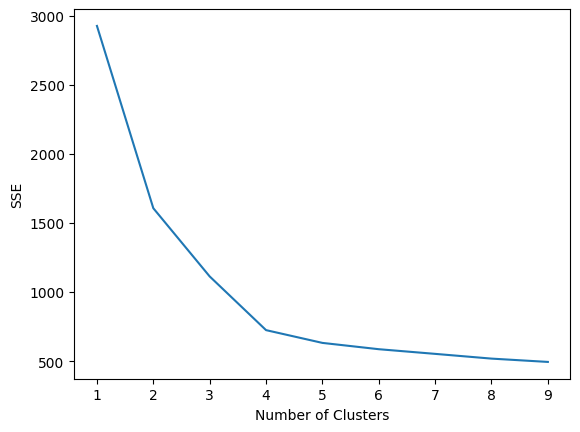

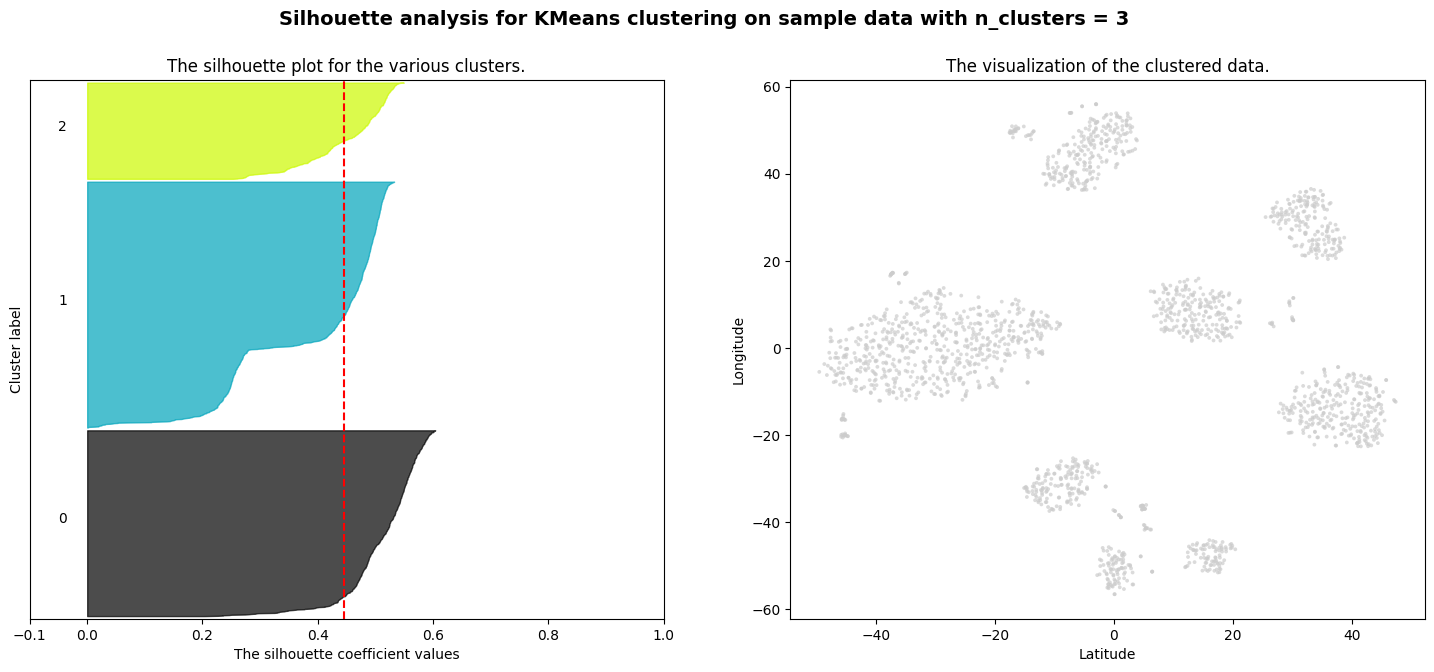

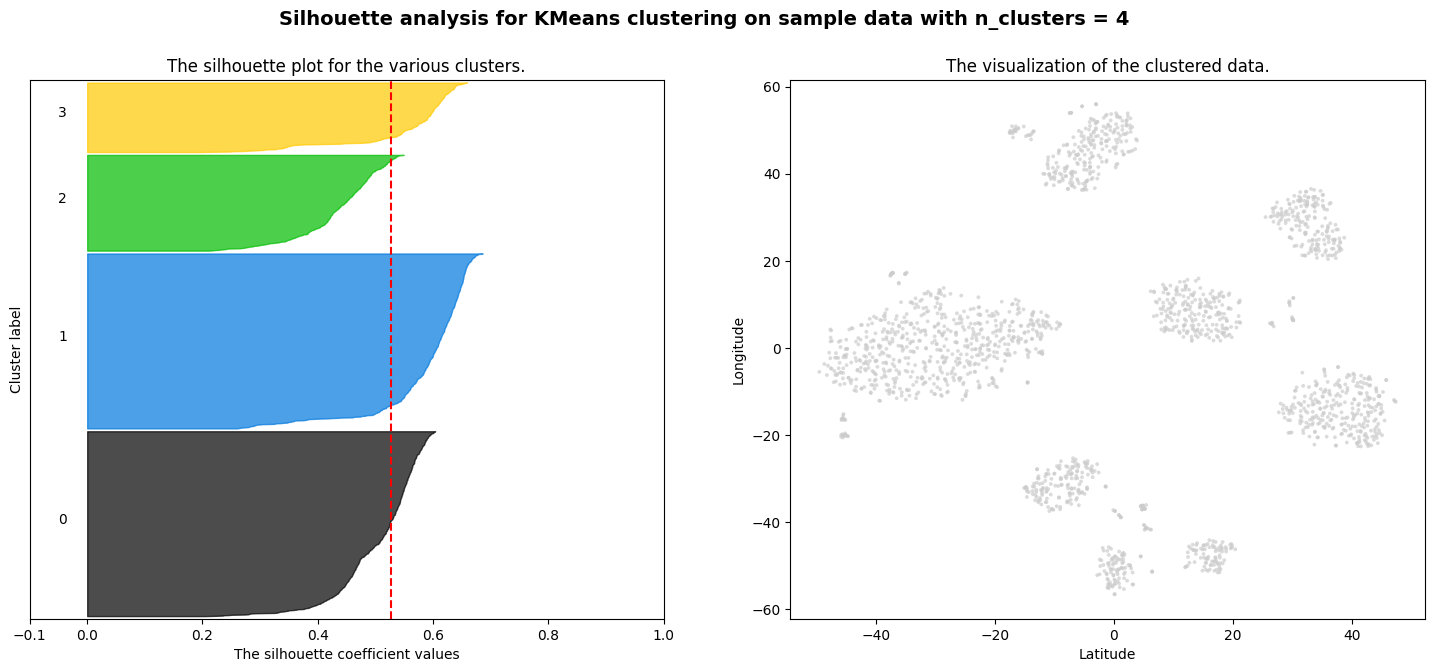

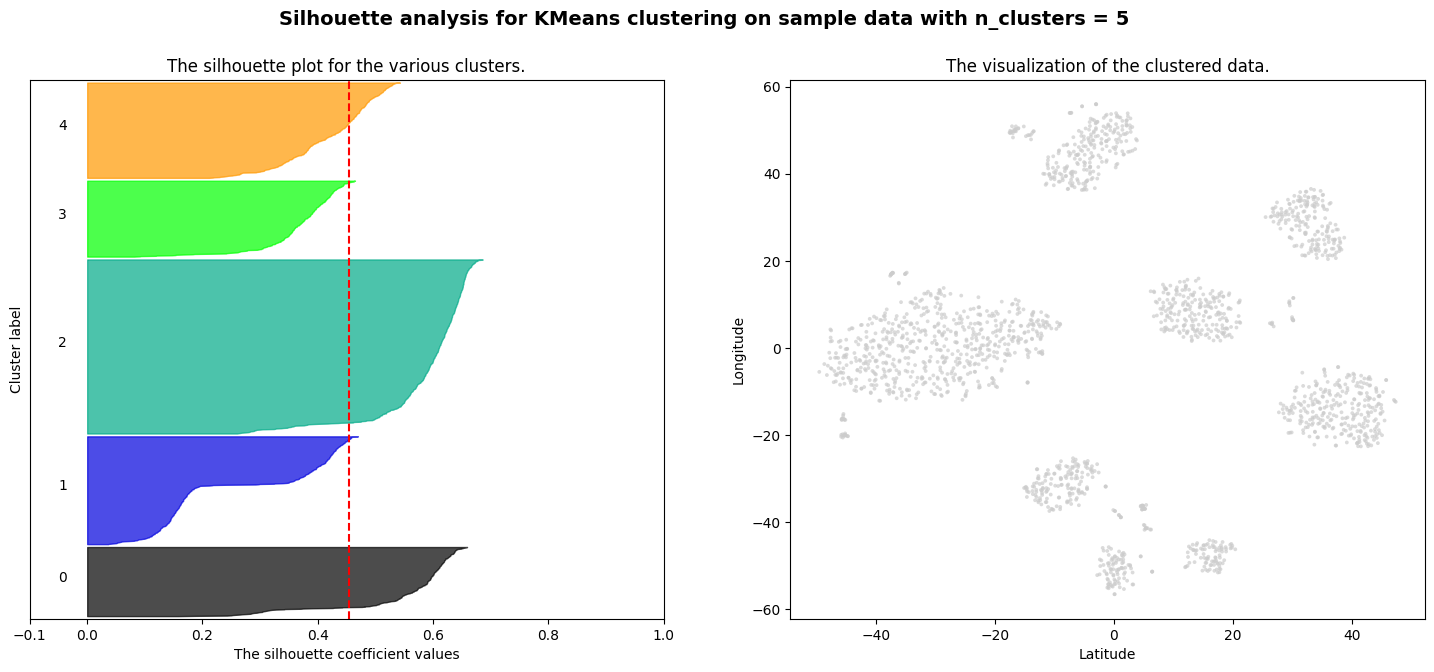

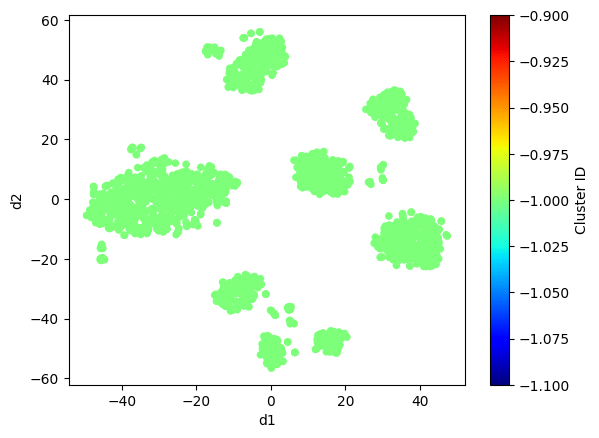

In [4]:

x_cols = ['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN']
df1 = df[x_cols]
x_cats = ['sex', 'DRK_YN']
df2 = pd.get_dummies(df1, columns=x_cats)
df2 = df2.sample(2000)
Y = df2['height']
scaler = MinMaxScaler()
X = scaler.fit_transform(df2)

numClusters = [1,2,3,4,5,6, 7, 8, 9]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(X)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

pca = TSNE(n_components=2)
X2 = pca.fit_transform(X)

df_X2 = pd.DataFrame(X2, columns=['d1', 'd2'])

X2.shape



# X = df2

range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    colors = cm.nipy_spectral(Y.astype(float) / 2)
#     ax2.scatter(
#         X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )
    ax2.scatter(
        X2[:, 0], X2[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
#     centers_2d = pca.transform(centers)
    # Draw white circles at cluster centers
#     ax2.scatter(
#         centers_2d[:, 0],
#         centers_2d[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers_2d):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Latitude")
    ax2.set_ylabel("Longitude")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

#plt.show()

db = DBSCAN(eps=0.025, min_samples=5).fit(X2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])


result = pd.concat((df_X2, labels), axis=1)


result.plot.scatter('d1', 'd2',c='Cluster ID', colormap='jet')



In [ ]:
data = data[['tot_chole','triglyceride']]
# scaler = MinMaxScaler()
# data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

db = DBSCAN(eps=15.5, min_samples=5).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])
result = pd.concat((data,labels), axis=1)
result.plot.scatter('tot_chole', 'triglyceride',c='Cluster ID', colormap='jet')

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or 